# 并发

## 多线程

`concurrency/multi_thread.py`

In [1]:
# encoding: utf8

import os
import re
import time
import queue
import requests
import threading

pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


def mt_download(url: str):
    """Multi thread download"""
    resp = requests.get(url)
    return resp.content


def mt_worker(i: int, q: queue.Queue):
    while not q.empty():
        url = q.get_nowait()
        if url is queue.Empty:
            return

        mt_download(url)
        q.task_done()


def mt_main(concurrency=4):
    content = mt_download(home_url)
    content = content.decode()

    q = queue.Queue()
    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        q.put_nowait(url)

    tasks = []
    for i in range(concurrency):
        task = threading.Thread(target=mt_worker, args=(i, q))
        task.start()
        tasks.append(task)

    for task in tasks:
        task.join()


# if __name__ == '__main__':
#     print(f'Start at {time.strftime("%X")}')
#     start_time = time.time()
#     mt_main(4)
#     print(f'Finished at {time.strftime("%X")}, elapse {int(time.time() - start_time)} seconds')



## 多进程

`concurrency/multi_process.py`

In [2]:
# encoding: utf8

import os
import re
import time
import queue
import requests
import multiprocessing as mp


pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


def mp_download(url: str):
    resp = requests.get(url)
    return resp.content


def mp_worker(i: int, q: mp.Queue):
    while not q.empty():
        url = q.get_nowait()
        if url is queue.Empty:
            return

        mp_download(url)


def mp_main(concurrency: int):
    q = mp.Queue()

    content = mp_download(home_url)
    content = content.decode()

    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        q.put(url)

    tasks = []
    for i in range(concurrency):
        p = mp.Process(target=mp_worker, args=(i, q))
        p.start()
        tasks.append(p)

    for p in tasks:
        p.join()


# if __name__ == '__main__':
#     print(f'Start at {time.strftime("%X")}')
#     start_time = time.time()
#     mp_main(4)
#     print(f'Finished at {time.strftime("%X")}, elapse {int(time.time() - start_time)} seconds')


## 协程

`concurrency/aio.py`

In [3]:
# encoding: utf8

import os
import re
import time
import asyncio
import aiohttp
import aiofiles

pdf_pattern = re.compile(">(\d+.+\.pdf)<")

home_url = 'https://courses.cs.washington.edu/courses/cse326/08sp/lectures/markup/'


async def aio_download(url: str):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as resp:
            content = await resp.read()
            return content


async def aio_main():
    content = await aio_download(home_url)
    content = content.decode()

    tasks = []
    for pdf in pdf_pattern.findall(content):
        url = os.path.join(home_url, pdf)
        task = asyncio.create_task(aio_download(url))
        tasks.append(task)

    await asyncio.gather(*tasks)


# if __name__ == '__main__':
#     start_time = time.time()
#     print(f'Start at {time.strftime("%X")}')
#     asyncio.run(aio_main())
#     print(f'Finished at {time.strftime("%X")}, elapse {int(time.time() - start_time)} seconds')


## 结论

`concurrency/main.py`

In [4]:
# encoding: utf8

import time
import asyncio

# from multi_process import mp_main
# from multi_thread import mt_main
# from aio import aio_main


def main():
    mt_concurrences = []
    mp_concurrences = []
    for concurrency in [2, 4, 8, 12]:
        start_tm = time.time()
        mt_main(concurrency)
        finish_tm = time.time()
        mt_concurrences.append(int(finish_tm - start_tm))
        print(f'multi thread concurrency {concurrency} elapse {int(finish_tm - start_tm)} seconds')

        start_tm = time.time()
        mp_main(concurrency)
        finish_tm = time.time()
        mp_concurrences.append(int(finish_tm - start_tm))
        print(f'multi process concurrency {concurrency} elapse {int(finish_tm - start_tm)} seconds')

    return mt_concurrences, mp_concurrences


# if __name__ == '__main__':
#     start_tm = time.time()
#     asyncio.run(aio_main())
#     finish_tm = time.time()
#     print(f'coroutine concurrency elapse {int(finish_tm - start_tm)} seconds')

#     print(main())


执行环境：

```
操作系统：MacOS
Core: 12
RAM: 32G
```

执行日志：

```
coroutine concurrency elapse 6 seconds
multi thread concurrency 2 elapse 47 seconds
multi process concurrency 2 elapse 37 seconds
multi thread concurrency 4 elapse 23 seconds
multi process concurrency 4 elapse 18 seconds
multi thread concurrency 8 elapse 11 seconds
multi process concurrency 8 elapse 12 seconds
multi thread concurrency 12 elapse 11 seconds
multi process concurrency 12 elapse 9 seconds
```

In [5]:
aio_tm = 6

In [6]:
concurrences = [2, 4, 8, 12]
mt_concurrency = [47, 23, 11, 11]
mp_concurrency = [37, 18, 12, 9]

In [9]:
import matplotlib.pyplot as plt

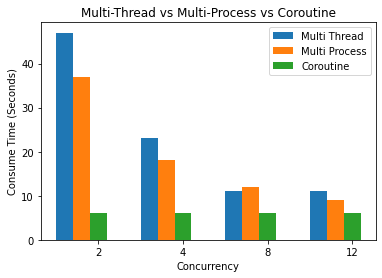

In [8]:
width = 0.2

# 多线程
x = list(range(len(concurrences)))
plt.bar(x, mt_concurrency, width=width, label='Multi Thread')

# 多进程
x = [v + width for v in x]
plt.bar(x, mp_concurrency, width=width, label='Multi Process')

# 协程
x = [v + width for v in x]
plt.bar(x, [aio_tm] * len(x), width=width, label='Coroutine', tick_label=concurrences)

plt.xlabel('Concurrency')
plt.ylabel('Consume Time (Seconds)')
plt.title('Multi-Thread vs Multi-Process vs Coroutine')
plt.legend()
plt.show()

* 异步IO的IO速度远大于多线程和多进程并发
* 对于网络IO，多进程的速度大于多线程，但相差不多